# **Прокруст, Облака & Крабы**

## Импорты

In [ ]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from math import sqrt, log
import numpy as np
from scipy.stats import boxcox, norm

# А зачем?

В биологии часто встречается аллометрия: асимметричный рост физических характеристик живых существ(см. картинку).

<img src="https://study.com/cimages/multimages/16/fiddler_crab_4_cropped9013030382232852017.jpeg">

Допустим, хочется исследовать какую-то выборку (например!) крабов на аллометрию.

In [ ]:
main_df = pl.read_csv("CrabAgePrediction.csv")
main_df = main_df.with_columns(
    pl.when(pl.col("Sex") == "F")
      .then(0)
      .when(pl.col("Sex") == "M")
      .then(1)
      .otherwise(-1)
      .alias("Sex")
)
main_df.head()

Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
i32,f64,f64,f64,f64,f64,f64,f64,i64
0,1.4375,1.175,0.4125,24.635715,12.332033,5.5848515,6.747181,9
1,0.8875,0.65,0.2125,5.40058,2.2963095,1.374951,1.5592225,6
-1,1.0375,0.775,0.25,7.952035,3.231843,1.601747,2.764076,6
0,1.175,0.8875,0.25,13.480187,4.748541,2.282135,5.2446575,10
-1,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.70097,6


In [ ]:
main_df = main_df.filter(
    (pl.col("Height") <= 1.0)
    & (pl.col("Weight") <= 70)
    & (pl.col("Shell Weight") <= 20)
)

In [ ]:
print(f"Число строк в датасете: {main_df.height}\n")
print(f"Число столбцов(признаков) в датасете: {main_df.width}")

Число строк в датасете: 3867

Число столбцов(признаков) в датасете: 9


Как видим, признаков много. Один из возможных подходов:
* посчитать $E_{X_i}$ для для признака $X_i$ и для каждого краба
* сравнить его фактическую характеритиску с ожидаемой
* добавить к счетчику аллометрий $1$, если одновременно что-то больше среднего, а что-то - меньше(по сути применить функцию `xor`)



Проблема: Было бы некорректно говорить о том, что у краба ассимметрия, если отклонение есть только по одному, возможно, ну совсем не значимому признаку.

Решение:
* применить `PCA`
* выделить $2$ наиболее значимых направления
* построить проекции
* проделать процедуру выше для проекций крабов
* Удостовериться в корректности действий

Проделаем описанное:

In [ ]:
X = main_df.to_numpy()
X_centered = X - X.mean(axis=0)
U, s, VT = np.linalg.svd(X_centered, full_matrices=False)
X_pca1_2 = U[:, :2] @ np.diag(s[:2])
X_pca2_3 = U[:, [1, 2]] @ np.diag(s[1:3])

Получилось два суть корреляционных облака:

In [ ]:
fig1_2 = px.scatter(
    x=X_pca1_2[:, 0],
    y=X_pca1_2[:, 1],
    labels={"x": "PC1", "y": "PC2"},
    title="2D PCA 1&2"
)

fig1_2.update_traces(marker=dict(color="orange"))

fig1_2.show()

In [ ]:
fig2_3 = px.scatter(
    x=X_pca2_3[:, 0],
    y=X_pca2_3[:, 1],
    labels={"x": "PC2", "y": "PC3"},
    title="2D PCA 2&3"
)

fig2_3.update_traces(marker=dict(color="red"))

fig2_3.show()

Коэффициент аллометрии составил:

In [ ]:
pca_df = pl.DataFrame(X_pca1_2, schema=["PC1", "PC2"])
mean_pc1 = pca_df["PC1"].mean()
mean_pc2 = pca_df["PC2"].mean()

pca_df = pca_df.with_columns(
    (pl.col("PC1") > mean_pc1).alias("check1"),
    (pl.col("PC2") > mean_pc2).alias("check2")
    )
pca_df = pca_df.with_columns(
    ((pl.col("check1") ^ pl.col("check2"))).alias("xor-allom")
    )
pca_df.head()

PC1,PC2,check1,check2,xor-allom
f64,f64,bool,bool,bool
2.015487,-1.633713,true,false,true
-20.814022,-1.565122,false,false,false
-17.96667,-1.751553,false,false,false
-11.422711,1.831579,false,true,true
-19.062512,-2.034631,false,false,false


In [ ]:
count_true = pca_df.filter(pl.col("xor-allom") == True).height
print(f"{round(count_true/pca_df.height, 3)*100}% крабов имеет аллометрию по PCA")

50.2% крабов имеет аллометрию по PCA


Однако давайте поговорим про корректность выбора именно двух направлений.

Действительно, мы знаем, что чем меньше сингулярное число, тем меньше оно дает информации по дисперсии векторов(крабов).

Однако именно в нашем случае почему корректно остановиться на $2$ признаках, если опускать удобство?

Показать корректность такого метода здесь можно, например, если спроецировать данные на $3$ и $4$ направления и показать, что полученная проекция близка к проекции на направления $1$ и $2$.

Показать этот факт можно, к примеру, через сравнение нормы разницы тождественного преобразования(единичной матрицы) и какого-то относительно простого преобразования, которые приближает все точки первой проекции ко второй, .

Если разница невелика, то облака в целом близки, поэтому не стоит рассматривать дополнительное направление, ведь оно не дают сильно новой информации по дисперсии, но может серьезно повлиять на коэффициент аллометрии ввиду близости распределения частот к плотности нормального распределения.

Если же разница будет существенна, то для анализа добавим новое направление.

Таким образом, мы имеем матрицы проекций на 1,2 и 2,3 направления соответственно: $$\overline{A}, \overline{B} \in M_{3867 \times 2}$$

Далее для удобства транспонируем их, приведем проекции крабов к виду векторов-столбцов:
$$A={\overline{A}}^t, B={\overline{B}}^t \in M_{2 \times 3867}$$

Хотим для них решить задачу поиска наилучшей в смысле аппроксимации матрицы $\Omega$ такой, что:
$$\Omega=argmin_{\Omega:\Omega^t\Omega=E}||\Omega A - B||$$

Также желаемая ортогональность искомой матрицы может быть объяснена еще и тем, что домножение слева на такую не меняет длину вектора:
$$QQ^t=E$$
$$||Qv||^2=(Qv)^t(Qv)=v^tQ^tQv=v^tEv=v^tv$$

# Непосредственно ***Проблема Прокруста***

А кто вообще такой Прокруст?

<img src="https://thoughtfullycatholic.wordpress.com/wp-content/uploads/2017/07/procrustes.gif?w=250&h=300&crop=1">

Теперь будем использовать конкретную норму - Фробеунисову - для решения следующей задачи:

$$min ||\Omega A - B||^{2}_F \space s.t. \Omega \Omega^t=E$$

Распишем норму Фробениуса по определению

$$||\Omega A - B||^{2}_F=\sum_{i,j}[(\Omega A - B)^{2}_{ij}$$

Применим формулу полного квадрата:

$$\sum_{i,j}[(\Omega A - B)^{2}_{ij}=\sum_{i,j}(\Omega A)^{2}_{ij}+B^2_{ij}-2(\Omega A)_{ij}(B)_{ij}]$$

Далее разобьём конечную сумму на 3 других и заметим, что для каждого из первых слагаемых образовалась в точности норма Фробениуса

$$\sum_{i,j}[(\Omega A)^{2}_{ij}+B^2_{ij}-2(\Omega A)_{ij}(B)_{ij}]=||\Omega A||^{2}_{F}+||B||^2_{F}-2\sum_{i,j}(\Omega A)_{ij}(B)_{ij}$$

Теперь перепишем норму Фробениуса для первого слагаемого через альтернативное определение:

$$||\Omega A||^{2}_{F}=tr([\Omega A]^t[\Omega A])=tr(A^t \Omega^t \Omega A)=tr(A^t E A)=tr(A^t A)=||A||^{2}_{F}$$

Поскольку матрицы $A, B$ являются заданными, задача свелась к $\sum_{i,j}(\Omega A)_{ij}(B)_{ij} \rightarrow max \space s.t. \Omega^t\Omega=E$

Далее перепишем максимизируемую сумму как $tr(B^t \Omega A)$ и воспользуемся свойством `tr`

$$tr(B^t \Omega A)=tr(\Omega A B^t )$$

Представим $AB^t$ через `SVD`

$$AB^t=U S V^t$$

Подставим в максимизируемую сумму и опять воспользуемся свойством `tr`

$$tr(\Omega U S V^t)=tr(V^t \Omega U S)=tr(ZS)$$

Поскольку по построению `SVD` $S$ - диагональная матрица, можем эквивалентно переписать

$$tr(ZS)=\sum_{i}Z_{ii}S_{ii}$$

Однако $Z$ - ортогональная матрица, а сингулярные числа, то есть элементы главной диагонали $S$, $\sigma_i=\sqrt{\lambda_i (AB^t (AB^t)^t)}>0$, отсюда $Z=E$ максимизирует `tr`, то есть искомая $\underline{\Omega=VU^t}$!!!!!

Реализуем это для нашей задачи:

In [ ]:
A_BT = X_pca1_2.transpose() @ X_pca2_3
U_supp, s_supp , V_supp_transp = np.linalg.svd(A_BT, full_matrices=False)

Получили следующую матрицу:

In [ ]:
omega = V_supp_transp.transpose() @ U_supp.transpose()
print(omega @ omega.transpose())
print(omega)

[[1. 0.]
 [0. 1.]]
[[-5.74668613e-16  1.00000000e+00]
 [-1.00000000e+00 -5.74668613e-16]]


Далее проверим точность и гипотезу об адекватности лишь 2 направлений

# Точность приближения

Рассмотрим искомый минимум в $argmin=\Omega$

In [ ]:
print(np.linalg.norm(X_pca1_2 @ omega.transpose() - X_pca2_3, "fro"))

972.5674004956248


Итак, в нашем случае $||\Omega A - B||_F\approx972$

Также узнаем, насколько сильно $\Omega$ отличается от тождественного преобразования - $E$



In [ ]:
print(np.linalg.norm(omega-np.eye(2), "fro"))

2.0000000000000004


Как можем видеть, наше значение $>1$, то есть точки не так уж близки! Поэтому следует рассмотреть проекцию на первые 3, а не 2 направления



In [ ]:
X = main_df.to_numpy()
X_centered = X - X.mean(axis=0)
U, s, VT = np.linalg.svd(X_centered, full_matrices=False)
X_pca3 = U[:, :3] @ np.diag(s[:3])
X_pca2_3 = U[:, [1, 2]] @ np.diag(s[1:3])

pca_df = pl.DataFrame(X_pca3, schema=["PC1", "PC2", "PC3"])
mean_pc1 = pca_df["PC1"].mean()
mean_pc2 = pca_df["PC2"].mean()
mean_pc3 = pca_df["PC3"].mean()

pca_df = pca_df.with_columns(
    (pl.col("PC1") > mean_pc1).alias("check1"),
    (pl.col("PC2") > mean_pc2).alias("check2"),
    (pl.col("PC3") > mean_pc3).alias("check3")
    )
pca_df = pca_df.with_columns(
    (
        ~((pl.col("check1") & pl.col("check2") & pl.col("check3")) |
          (~pl.col("check1") & ~pl.col("check2") & ~pl.col("check3")))
    ).alias("xor-allom")
)
pca_df.head()

PC1,PC2,PC3,check1,check2,check3,xor-allom
f64,f64,f64,bool,bool,bool,bool
2.015487,-1.633713,0.909211,true,false,true,true
-20.814022,-1.565122,-0.35314,false,false,false,false
-17.96667,-1.751553,-0.926379,false,false,false,false
-11.422711,1.831579,-0.731735,false,true,false,true
-19.062512,-2.034631,0.010901,false,false,true,true


In [ ]:
count_true = pca_df.filter(pl.col("xor-allom") == True).height
print(f"{round(count_true/pca_df.height, 3)*100}% крабов имеет аллометрию по PCA")

71.8% крабов имеет аллометрию по PCA


Вспомним первичные корреляционные облака:

In [ ]:
fig1_2.show()

In [ ]:
fig2_3.show()

In [ ]:
fig_procrustes = px.scatter(
    x=(X_pca1_2 @ omega.transpose())[:, 0],
    y=(X_pca1_2 @ omega.transpose())[:, 1],
    labels={"x": "PC2", "y": "PC3"},
    title="2D PCA 2&3 Procrustes"
)

fig_procrustes.update_traces(marker=dict(color="orange"))

fig_procrustes.show()

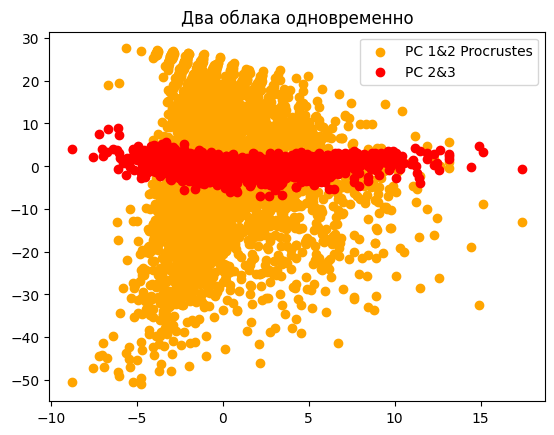

In [ ]:

plt.scatter((X_pca1_2 @ omega.transpose())[:, 0], (X_pca1_2 @ omega.transpose())[:, 1], label='PC 1&2 Procrustes', color="orange")

plt.scatter(pca_df["PC2"], pca_df["PC3"], label='PC 2&3', color="red")

plt.title("Два облака одновременно")
plt.legend()

plt.show()

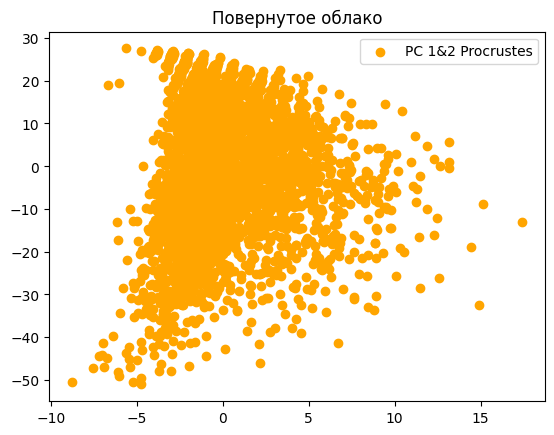

In [ ]:
plt.scatter((X_pca1_2 @ omega.transpose())[:, 0], (X_pca1_2 @ omega.transpose())[:, 1], label='PC 1&2 Procrustes', color="orange")

plt.title("Повернутое облако")
plt.legend()

plt.show()

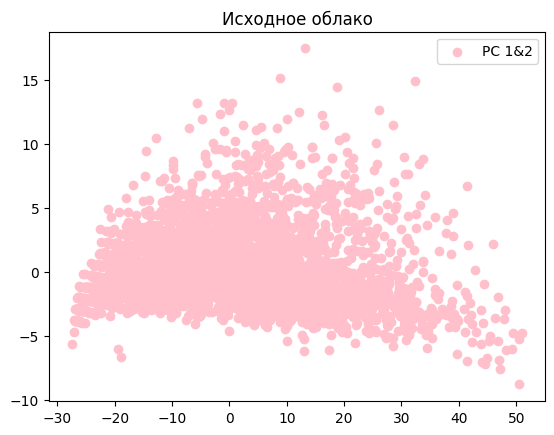

In [ ]:
plt.scatter(pca_df["PC1"], pca_df["PC2"], label="PC 1&2", color="pink")

plt.title("Исходное облако")
plt.legend()

plt.show()

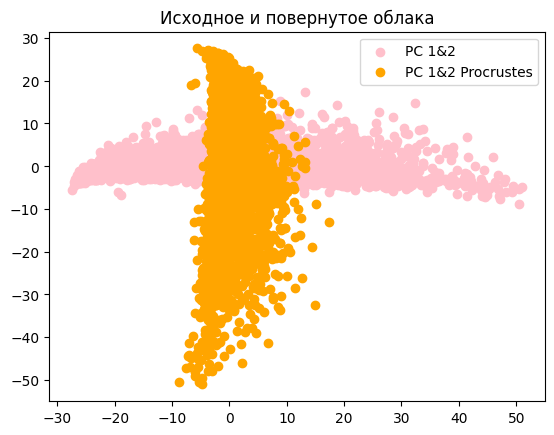

In [ ]:
plt.scatter(pca_df["PC1"], pca_df["PC2"], label="PC 1&2", color="pink")
plt.scatter((X_pca1_2 @ omega.transpose())[:, 0], (X_pca1_2 @ omega.transpose())[:, 1], label='PC 1&2 Procrustes', color="orange")



plt.title("Исходное и повернутое облака")
plt.legend()

plt.show()

# Есть ли что-то еще?

Да!

* Проблема Прокруста для матриц поворота, т.е. $\Omega \in SO(n)$
* Проблеа Прокруста для $A \in M_{nl}(\mathbb{C}), B \in M_{nm}(\mathbb{C}), \Omega \in U(l, m) \subset M_{ln}(\mathbb{C})$

Причем последняя проблема пока не имеет **явного универсального решения.**